In [1]:
from scipy.io import wavfile
import scipy.io
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from numpy.linalg import inv

# Read all input files ....
piano = wavfile.read('Piano_Clap.wav')
piano_mat = piano[1]

m = scipy.io.loadmat('mfcc.mat')
mfcc = m['X']
mu = scipy.io.loadmat('MuSigma.mat')

/opt/anaconda3/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [2]:
means = mu['mX']
cov = mu['Sigma']
cov_piano = cov[:,:,0]
cov_clap = cov[:,:,1]

# Matrix preparation
mean_piano = means[:,0]
mean_piano = mean_piano.reshape((12,1))
mean_clap = means[:,1]
mean_clap = mean_clap.reshape((12,1))

x_mean_pi = mfcc - mean_piano
x_mean_clap = mfcc - mean_clap

cov_piano_inv = inv(np.matrix(cov_piano))
cov_clap_inv = inv(np.matrix(cov_clap))

cov_piano_mod = math.sqrt(np.sqrt((cov_piano * cov_piano).sum()))
cov_clap_mod = math.sqrt(np.sqrt((cov_clap * cov_clap).sum()))

def gaussian(x_u,cov_mod,cov_inv):
    n1 = 1 / (2 * 3.14 * cov_mod)
    n2 = -np.exp(-0.5 * np.dot(np.dot(x_u.T, cov_inv),x_u))
    return n1*n2

In [3]:
piano_list = []
clap_list = []
for i in range(962):
    pi = gaussian(x_mean_pi[:, i].reshape((12, 1)), cov_piano_mod, cov_piano_inv)
    piano_list.append(pi[0, 0])

    cl = gaussian(x_mean_clap[:, i].reshape((12, 1)), cov_clap_mod, cov_clap_inv)
    clap_list.append(cl[0, 0])

p = np.array([piano_list,clap_list])
p_sum = np.sum(p,axis=0).reshape((1,962))
p_tilda = p / p_sum

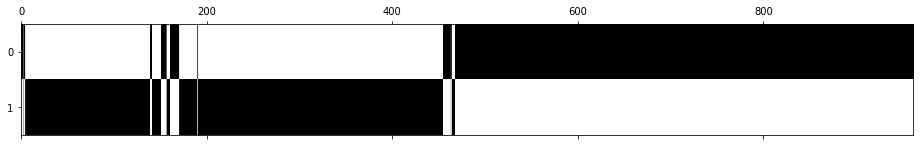

In [4]:
plt.matshow(p_tilda,aspect='auto',cmap="gray")
plt.show()

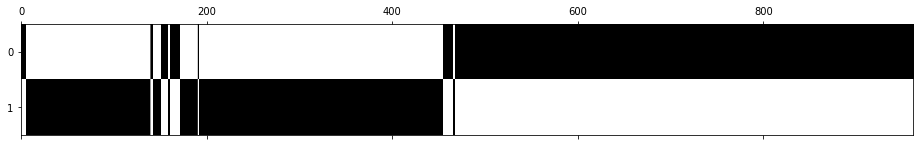

In [5]:
t = np.array([[0.9,0.1],[0,1]])
p_bar = np.zeros((2,962))
p_bar[:,0] = p_tilda[:,0]

for i in range(0,961):
    b = np.argmax(p_tilda[:,i])
    p_bar[:,i+1] = t[b,:] * p_tilda[:,i+1]

p_bar_sum = np.sum(p_bar,axis=0).reshape((1,962))
p_bar = p_bar/p_bar_sum

plt.matshow(p_bar,aspect='auto',cmap="gray")
plt.show()

B = np.zeros((2, 962))
p_bar2 = np.zeros((2, 962))
p_bar2[:, 0] = p_tilda[:, 0]

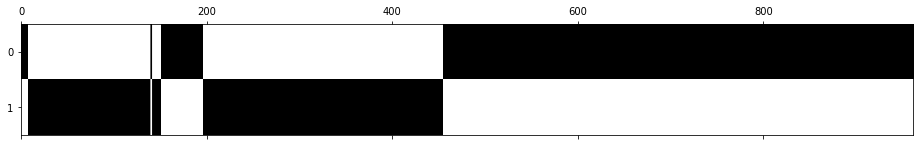

In [6]:
for i in range(961):
    b1 = np.argmax(np.multiply(t[:, 0], p_bar2[:, i]))
    B[0, i + 1] = b1
    p_bar2[0, i + 1] = np.dot(np.dot(t[b1, 0], p_bar2[b1, i]), p[0, i + 1])

    b2 = np.argmax(np.multiply(t[:, 1], p_bar2[:, i]))
    B[1, i + 1] = b2
    p_bar2[1, i + 1] = np.dot(np.dot(t[b2, 1], p_bar2[b2, i]), p[1, i + 1])
    p_bar2[:, i + 1] = p_bar2[:, i + 1] / np.sum(p_bar2[:, i + 1])

plt.matshow(p_bar2, aspect='auto', cmap="gray")
plt.show()

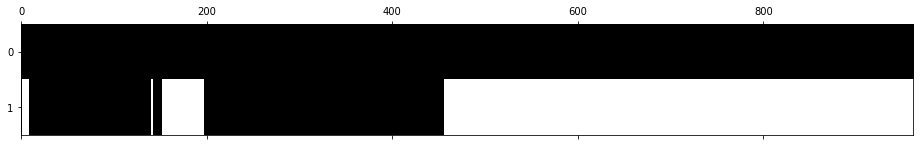

In [7]:
plt.matshow(B, aspect='auto', cmap="gray")
plt.show()

In [8]:
states = []
m = np.argmax(p_bar2[:,961])
item = int(B[m,961])
states.append(B[m,961])
for i in reversed(range(961)):
    states.append(B[item,i])
    item = int(B[item,i])

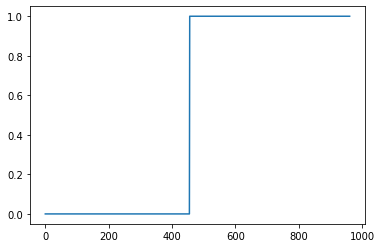

In [9]:
plt.plot(states[::-1])
plt.show()